In [1]:
# ARIMA model for forecasting milk price

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('monthly-milk-production-pounds-p.csv')
df.head()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
0,1962-01,589.0
1,1962-02,561.0
2,1962-03,640.0
3,1962-04,656.0
4,1962-05,727.0


In [3]:
df.tail()

,Month,Monthly milk production: pounds per cow. Jan 62 ? Dec 75
164,1975-09,817.0
165,1975-10,827.0
166,1975-11,797.0
167,1975-12,843.0
168,Monthly milk production: pounds per cow. Jan 6...,NaN


In [4]:
# Data cleaning

df.columns = ['Month','Milk in pounds per cow']
df.drop(168,axis=0,inplace=True)
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month',inplace=True)
df.head()

,Milk in pounds per cow
Month,
1962-01-01,589.0
1962-02-01,561.0
1962-03-01,640.0
1962-04-01,656.0
1962-05-01,727.0


<AxesSubplot:xlabel='Month'>

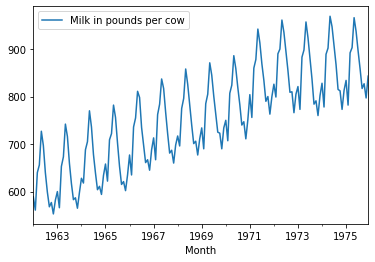

In [5]:
# Visualising the data

df.plot()

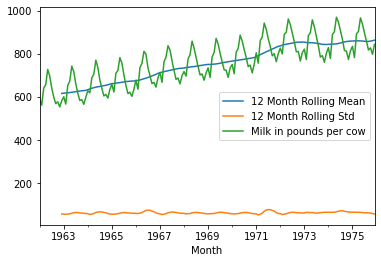

In [6]:
timeseries = df['Milk in pounds per cow']
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std')
timeseries.plot()
plt.legend()

In [7]:
# Now test for stationarity using Augmented Dickey Fuller Test in order to perform ARIMA 

from statsmodels.tsa.stattools import adfuller

def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
adf_check(df['Milk in pounds per cow'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -1.3038115874221246
p-value : 0.627426708603034
#Lags Used : 13
Number of Observations Used : 154
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [8]:
# Data is non stationary (seasonal), so we need to do differencing to make it stationary

df['Milk First Difference'] = df['Milk in pounds per cow'] - df['Milk in pounds per cow'].shift(1)
adf_check(df['Milk First Difference'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -3.0549955586530553
p-value : 0.03006800400178688
#Lags Used : 14
Number of Observations Used : 152
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [9]:
# Now data is stationary, so we can start with our ARIMA model

from statsmodels.tsa.arima_model import ARIMA

In [10]:
model = sm.tsa.statespace.SARIMAX(df['Milk in pounds per cow'],order=(0,1,0), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

# p: The number of lag observations included in the model.
# d: The number of times that the raw observations are differenced, also called the degree of differencing.
# q: The size of the moving average window, also called the order of moving average.

C:\Users\Ameya\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\Ameya\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


                                      SARIMAX Results                                       
Dep. Variable:               Milk in pounds per cow   No. Observations:                  168
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 12)   Log Likelihood                -534.065
Date:                              Tue, 20 Jul 2021   AIC                           1074.131
Time:                                      16:13:20   BIC                           1083.261
Sample:                                  01-01-1962   HQIC                          1077.839
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.0449      0.106     -0.422      0.673      -0.253       0.163
ma.S.L12      -0.58

<AxesSubplot:xlabel='Month'>

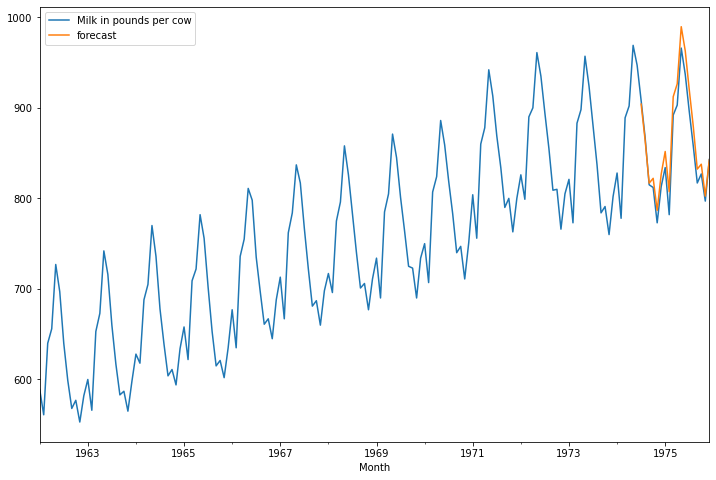

In [11]:
# Prediction of future values

df['forecast'] = results.predict(start = 150, end= 168, dynamic= True)  
df[['Milk in pounds per cow','forecast']].plot(figsize=(12,8))

In [12]:
from sklearn.metrics import mean_squared_error
import math
fc=df['forecast'][150:]
test_data=df['Milk in pounds per cow'][150:]
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('Mean Absolute Percentage Error: '+str(mape))

Mean Absolute Percentage Error: 0.016828355042960142


In [13]:
# Our model has done well, just 1.68% error, therefore accuracy of 98.32%

In [14]:
# For forecasting, we need to create more time periods, we'll see the tail of the dataframe to see which dates to add

df.tail()

,Milk in pounds per cow,Milk First Difference,forecast
Month,,,
1975-08-01,858.0,-38.0,879.668974
1975-09-01,817.0,-41.0,832.328554
1975-10-01,827.0,10.0,837.722250
1975-11-01,797.0,-30.0,802.452736
1975-12-01,843.0,46.0,842.499870


In [15]:
from pandas.tseries.offsets import DateOffset
future_dates = [df.index[-1] + DateOffset(months=x) for x in range(0,24) ]
future_dates

[Timestamp('1975-12-01 00:00:00'),
 Timestamp('1976-01-01 00:00:00'),
 Timestamp('1976-02-01 00:00:00'),
 Timestamp('1976-03-01 00:00:00'),
 Timestamp('1976-04-01 00:00:00'),
 Timestamp('1976-05-01 00:00:00'),
 Timestamp('1976-06-01 00:00:00'),
 Timestamp('1976-07-01 00:00:00'),
 Timestamp('1976-08-01 00:00:00'),
 Timestamp('1976-09-01 00:00:00'),
 Timestamp('1976-10-01 00:00:00'),
 Timestamp('1976-11-01 00:00:00'),
 Timestamp('1976-12-01 00:00:00'),
 Timestamp('1977-01-01 00:00:00'),
 Timestamp('1977-02-01 00:00:00'),
 Timestamp('1977-03-01 00:00:00'),
 Timestamp('1977-04-01 00:00:00'),
 Timestamp('1977-05-01 00:00:00'),
 Timestamp('1977-06-01 00:00:00'),
 Timestamp('1977-07-01 00:00:00'),
 Timestamp('1977-08-01 00:00:00'),
 Timestamp('1977-09-01 00:00:00'),
 Timestamp('1977-10-01 00:00:00'),
 Timestamp('1977-11-01 00:00:00')]

In [16]:
future_dates_df = pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [17]:
future_dates_df.head()

,Milk in pounds per cow,Milk First Difference,forecast
1976-01-01,NaN,NaN,NaN
1976-02-01,NaN,NaN,NaN
1976-03-01,NaN,NaN,NaN
1976-04-01,NaN,NaN,NaN
1976-05-01,NaN,NaN,NaN


In [18]:
future_df = pd.concat([df,future_dates_df])
future_df.tail()

,Milk in pounds per cow,Milk First Difference,forecast
1977-07-01,NaN,NaN,NaN
1977-08-01,NaN,NaN,NaN
1977-09-01,NaN,NaN,NaN
1977-10-01,NaN,NaN,NaN
1977-11-01,NaN,NaN,NaN


Text(0.5, 1.0, 'Future Dates Prediciton')

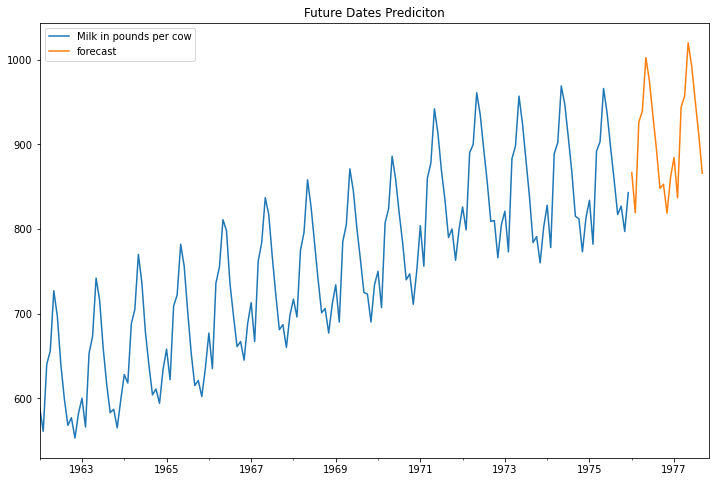

In [19]:
future_df['forecast'] = results.predict(start = 168, end = 188, dynamic= True)  
future_df[['Milk in pounds per cow', 'forecast']].plot(figsize=(12, 8))
plt.title('Future Dates Prediciton')